In [1]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

from utils.chromo_cv_utils import cv_imread, cv_imwrite

In [2]:
# 二值化使用OTSU算法后的校正值
OTSU_PLUS = 20

# 杂质上限，小于该大小的轮廓直接丢弃
CNT_AREA_MIN = 80

# 待去除杂质的轮廓的最大面积
CNT_AREA_MAX = 1000000

# 待去除大轮廓的筛选下限，再此基础上再根据外形就行区分
CNT_AREA_MAX = 10000

# 过滤不显著凹陷（凸缺陷）的阈值
CONCAVE_DEPTH_THRESH = 5000  # 可以根据需要调整

In [3]:
# 读取图片
# img_fp = 'E:/染色体测试数据/241021-染色体畸变数据-cv办法找染色体/2024_10_16_20_54_46_670fa80ec4ba273a0afb8d02_00591.jpg'
img_fp = 'E:/染色体测试数据/241021-染色体畸变数据-cv办法找染色体/2024_10_16_20_55_25_670fa80ec4ba273a0afb8d02_00597.jpg'
img_fn = os.path.basename(img_fp)
img_fn = os.path.splitext(img_fn)[0]
img_fext = os.path.splitext(img_fp)[1]
img_fdir = os.path.dirname(img_fp)
img_lst = []
img = cv_imread(img_fp)

In [4]:
# 灰化，二值化
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
binary_val = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[0] # cv2.THRESH_TRIANGLE, cv2.THRESH_OTSU
binary = cv2.threshold(gray, binary_val+OTSU_PLUS, 255, cv2.THRESH_BINARY_INV)[1]

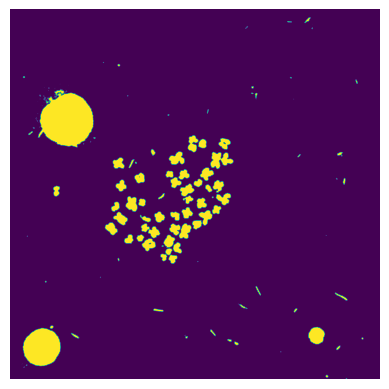

In [5]:
# 显示图片
plt.imshow(binary)
plt.axis('off')  # 关闭坐标轴
plt.show()

In [6]:
# 在二值化图上求轮廓，然后将轮廓画在原图上
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
canvas = img.copy()
cv2.drawContours(canvas, contours, -1, (0, 0, 255), 2)
len(contours)

246

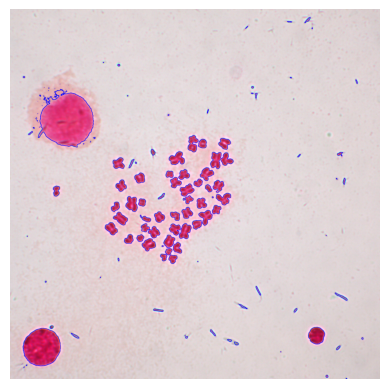

In [7]:
# 显示图片
plt.imshow(canvas)
plt.axis('off')  # 关闭坐标轴
plt.show()

In [8]:
# 保存被画上轮廓的图片
save_fp = os.path.join(img_fdir, f'{img_fn}_contours{img_fext}')
cv_imwrite(save_fp, canvas)

In [9]:
# 根据轮廓大小来过滤
cnt_areas = [cv2.contourArea(cnt) for cnt in contours]
small_contours = [cnt for cnt in contours if cv2.contourArea(cnt) <= CNT_AREA_MIN]
mid_contours = [cnt for cnt in contours if CNT_AREA_MIN < cv2.contourArea(cnt) < CNT_AREA_MAX]
big_contours = [cnt for cnt in contours if cv2.contourArea(cnt) >= CNT_AREA_MAX]
max(cnt_areas), min(cnt_areas), len(small_contours), len(mid_contours), len(big_contours)

(106125.0, 0.0, 169, 73, 4)

In [10]:
# 求大轮廓的凸缺陷
big_cnt = big_contours[2]
hull = cv2.convexHull(big_cnt, returnPoints=False)

# 找到凸缺陷（凹点）
defects = cv2.convexityDefects(big_cnt, hull)

# 画出big_cnt的轮廓
canvas = img.copy()
cv2.drawContours(canvas, [big_cnt], -1, (255, 0, 0), 1)

# 显示凸缺陷
if defects is not None:
    defects = cv2.convexityDefects(big_cnt, hull)
    for i in range(defects.shape[0]):
        s, e, f, d = defects[i, 0]

        # 过滤掉不显著的凸缺陷,深度d小于阈值会被忽略
        if d > CONCAVE_DEPTH_THRESH:
            start = tuple(big_cnt[s][0])
            end = tuple(big_cnt[e][0])
            far = tuple(big_cnt[f][0])
            # 画出凸缺陷
            cv2.line(canvas, start, end, [0, 255, 0], 2)
            cv2.circle(canvas, far, 5, [0, 0, 255], -1)

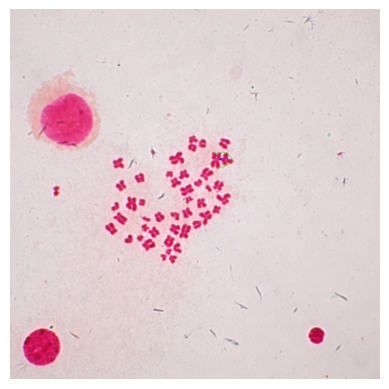

In [11]:
# 显示图片
plt.imshow(canvas)
plt.axis('off')  # 关闭坐标轴
plt.show()

In [12]:
# save
save_fp = os.path.join(img_fdir, f'{img_fn}_big_cnt_concave_{img_fext}')
cv_imwrite(save_fp, canvas)